In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from monai.networks.nets import BasicUNet
from monai.losses.dice import GeneralizedDiceLoss
from torchvision.transforms import functional as TF
import random
import time
from lib.dataset.PH2Dataset import get_PH2_datasets
from lib.losses import DiceLoss,BCELoss


In [2]:
size = 128
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

train_ds, val_ds, test_ds = get_PH2_datasets(transform=transform)
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
test_loader = DataLoader(test_ds, batch_size=8)



Found 200 images and 200 masks
Example image path: /dtu/datasets1/02516/PH2_Dataset_images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp
Example mask path: /dtu/datasets1/02516/PH2_Dataset_images/IMD002/IMD002_lesion/IMD002_lesion.bmp
Train size: 140, Val size: 20, Test size: 40


In [3]:

# Print a sample batch shape
for images, masks in train_loader:
    print(f"Images Shape: {images.shape}")  # Expected: (batch_size, 11, H, W)
    print(f"Masks Shape: {masks.shape}")    # Expected: (batch_size, 1, H, W)
    break



Images Shape: torch.Size([8, 3, 128, 128])
Masks Shape: torch.Size([8, 1, 128, 128])


In [4]:
num_gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

learning_rate = 0.001


# Initialize model, loss function, and optimizer
model = BasicUNet(
    spatial_dims=2,  # Change to 2 if you're working with 2D images
    in_channels=3,
    out_channels=2,
    features = (32, 64, 128, 256, 512, 32),
    dropout=0.2
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adjust the learning rate as needed
loss_fn = GeneralizedDiceLoss(include_background=False,to_onehot_y=True,softmax=False)


BasicUNet features: (32, 64, 128, 256, 512, 32).


In [5]:
import copy

num_epochs = 5

train_losses = []
val_losses = []

epoch_losses =[]
val_epoch_losses = []

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    batch_count = 0

    for inputs, masks in train_loader:
 
        inputs = inputs.to(device)
        masks = masks.to(device)

        # set parameter gradients to zero
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.softmax(dim=1)

        loss = loss_fn(outputs, masks)
        train_losses.append(loss.item())
        epoch_loss += loss.item()
        batch_count += 1

        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()

    # Print loss for each epoch
    epoch_loss = epoch_loss / batch_count
    epoch_losses.append(epoch_loss)
    print("Epoch: {}, Train Loss: {}".format(epoch, epoch_loss))

    # Evaluation/Validation step (optional)
    model.eval()
    with torch.no_grad():
        val_epoch_loss = 0.0
        val_batch_count = 0
        for val_inputs, val_masks in val_loader:  # Or use a separate validation loader
            val_inputs = val_inputs.to(device)
            val_masks = val_masks.to(device)


            prediction = model(val_inputs)
            prediction = prediction.softmax(dim=1)
            
            val_loss = loss_fn(prediction, val_masks)
            val_losses.append(val_loss.item())
            val_epoch_loss += val_loss.item()
            val_batch_count += 1

    val_epoch_loss = val_epoch_loss / val_batch_count
    val_epoch_losses.append(val_epoch_loss)
    print("Epoch: {},  Val Loss: {}".format(epoch, val_epoch_loss))
    # ---- Save best model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Best model updated at epoch {epoch} with val loss: {best_val_loss:.4f}")

# Directory to save the loss plot
plots_dir = "/zhome/7b/3/168395/02516/02516_exercise/plots"
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference : {inference_time:.4f} seconds")

# Directory to save the trained model
model_save_dir = "/zhome/7b/3/168395/02516/02516_exercise/"
os.makedirs(model_save_dir, exist_ok=True)  # Create directory if it doesn't exist

if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
else:
    print("Warning: best_model_wts is None — loading current model weights instead.")

model_path = os.path.join(model_save_dir, "trained_unet_model.pth")

# Save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved at '{model_path}'")

# Save loss plot
def save_loss_plot(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plot_path = os.path.join(plots_dir, "loss_plot_unet.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Loss plot saved as '{plot_path}'")   

save_loss_plot(epoch_losses,val_epoch_losses,num_epochs)



Epoch: 0, Train Loss: 0.4312542676925659
Epoch: 0,  Val Loss: 0.29821522037188214
Best model updated at epoch 0 with val loss: 0.2758
Epoch: 1, Train Loss: 0.3408143114712503
Epoch: 1,  Val Loss: 0.2561366508404414
Best model updated at epoch 1 with val loss: 0.2229
Epoch: 2, Train Loss: 0.29623794472879833
Epoch: 2,  Val Loss: 0.19893547892570496
Best model updated at epoch 2 with val loss: 0.1650
Epoch: 3, Train Loss: 0.2608468408385913
Epoch: 3,  Val Loss: 0.17391869922478995
Best model updated at epoch 3 with val loss: 0.1311
Epoch: 4, Train Loss: 0.22365732739369074
Epoch: 4,  Val Loss: 0.15002344300349554
Best model updated at epoch 4 with val loss: 0.1207
Inference : 237.9737 seconds
Model saved at '/zhome/7b/3/168395/02516/02516_exercise/trained_unet_model.pth'
Loss plot saved as '/zhome/7b/3/168395/02516/02516_exercise/plots/loss_plot_unet.png'


In [6]:
print("-----------now testing-----------")
# Testing
model.eval()
predictions_dir = "/zhome/7b/3/168395/02516/02516_exercise/pree"
test_loss = 0.0
total_samples = len(test_loader.dataset)
start_time = time.time()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass through the model
        segmentation_output = model(images)
        segmentation_output = segmentation_output.softmax(dim=1)
        
        # Calculate the loss
        loss = loss_fn(segmentation_output, masks)
        test_loss += loss.item()

        preds = torch.argmax(segmentation_output, dim=1)

        # Save each prediction
        for i in range(preds.shape[0]):
            plt.figure(figsize=(8, 8))
            plt.imshow(preds[i].cpu().numpy(), cmap='gray')
            plt.axis('off')

            # Generate a unique filename for each prediction
            prediction_path = os.path.join(predictions_dir, f"prediction_{idx * preds.shape[0] + i}.png")
            plt.savefig(prediction_path, bbox_inches='tight', pad_inches=0)
            plt.close()
end_time = time.time()

# Compute average test loss and IoU
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

print(f"Predictions saved in '{predictions_dir}' folder.")
inference_time = end_time - start_time
print(f"Inference : {inference_time:.4f} seconds")

-----------now testing-----------


Test Loss: 0.2172
Predictions saved in '/zhome/7b/3/168395/02516/02516_exercise/pree' folder.
Inference : 7.1466 seconds


Example indices for visualization: [0, 1, 2, 3, 4]


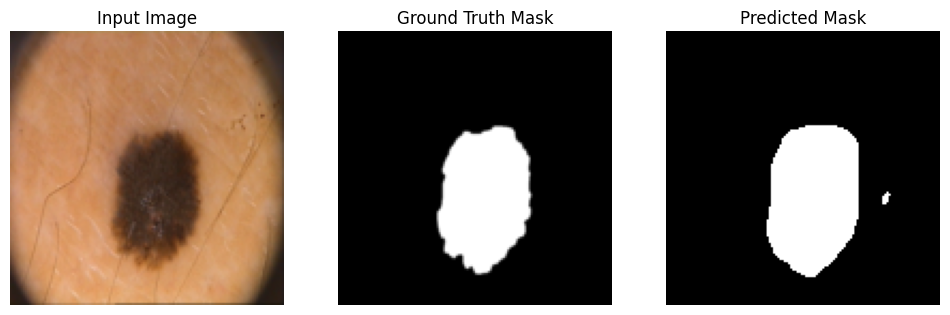

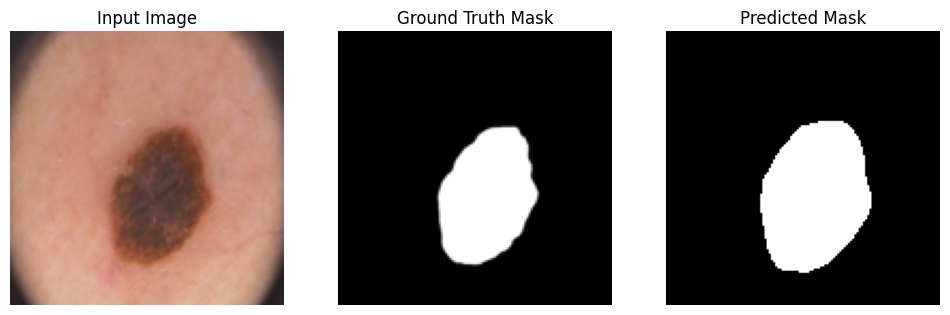

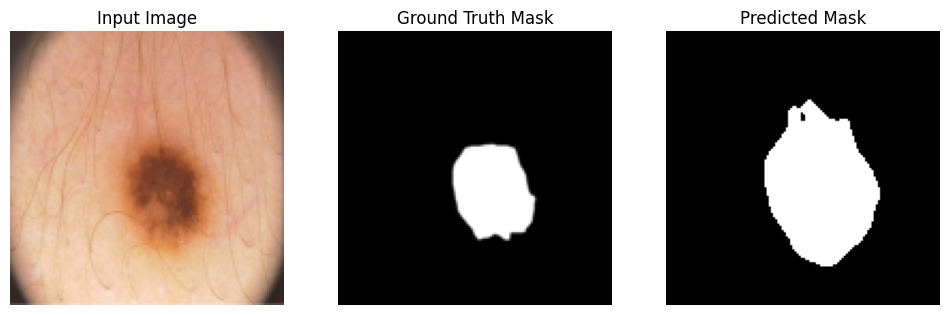

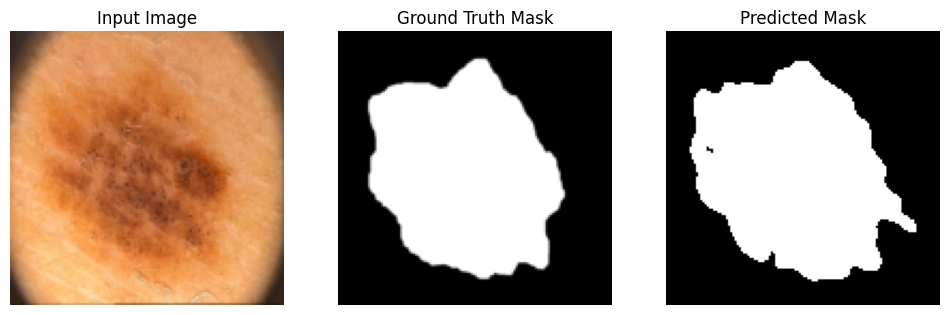

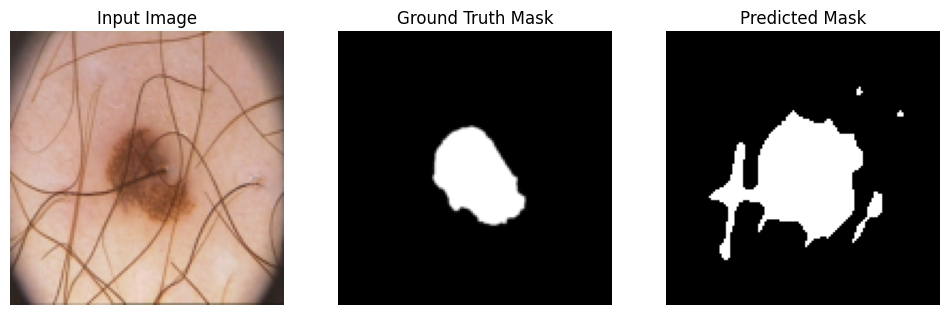

In [7]:
# plot examples
plots_dir = "/zhome/7b/3/168395/02516/02516_exercise/plots"
os.makedirs(plots_dir, exist_ok=True)
example_indices = [0, 1, 2, 3, 4] 
print("Example indices for visualization:", example_indices)
for idx in example_indices:
    image, mask = test_ds[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to
    prediction = model(image)
    prediction = prediction.softmax(dim=1)
    pred_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image.squeeze(0).cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask.squeeze(0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    plt.show()